## 데이터마이닝 프로젝트

In [931]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')


In [932]:
# 데이터 로드

FP_PATH    = "floating_population.csv"   # 유동인구
SALES_PATH = "sales.csv"                 # 매출
STORE_PATH = "store.csv"                 # 점포


In [933]:
def read_korean_csv(path: str) -> pd.DataFrame:
    """Try common Korean encodings."""
    for enc in ("utf-8", "cp949", "euc-kr"):
        try:
            return pd.read_csv(path, encoding=enc)
        except UnicodeDecodeError:
            continue
    return pd.read_csv(path)

fp    = read_korean_csv(FP_PATH)
fp = fp[fp["기준_년분기_코드"] // 10 == 2024]
sales = read_korean_csv(SALES_PATH)
store = read_korean_csv(STORE_PATH)

print(fp.shape, sales.shape, store.shape)


(1700, 25) (67900, 53) (141001, 12)


In [934]:
f = lambda x: display(x["기준_년분기_코드"].unique())
f(fp)
f(sales)
f(store)

array([20241, 20242, 20243, 20244])

array([20241, 20242, 20243, 20244])

array([20241, 20242, 20243, 20244])

In [935]:
def get_columns(df):
    display(df.columns)
get_columns(fp)
get_columns(sales)
get_columns(store)

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '총_유동인구_수', '남성_유동인구_수', '여성_유동인구_수',
       '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수',
       '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수', '시간대_00_06_유동인구_수',
       '시간대_06_11_유동인구_수', '시간대_11_14_유동인구_수', '시간대_14_17_유동인구_수',
       '시간대_17_21_유동인구_수', '시간대_21_24_유동인구_수', '월요일_유동인구_수', '화요일_유동인구_수',
       '수요일_유동인구_수', '목요일_유동인구_수', '금요일_유동인구_수', '토요일_유동인구_수', '일요일_유동인구_수'],
      dtype='object')

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '서비스_업종_코드', '서비스_업종_코드_명',
       '당월_매출_금액', '당월_매출_건수', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '남성_매출_건수', '여성_매출_건수',
       '연령대_10_매출_건수', '연령대_20_매출_건수', '연령대_30_매출_건수', '연령대_40_매출_건수',
       '연령대_50_매출_건수', '연령대_60_이상_매출_건수'],
      dtype='object')

Index(['기준_년분기_코드', '행정동_코드', '행정동_코드_명', '서비스_업종_코드', '서비스_업종_코드_명', '점포_수',
       '유사_업종_점포_수', '개업_율', '개업_점포_수', '폐업_률', '폐업_점포_수', '프랜차이즈_점포_수'],
      dtype='object')

In [936]:
#데이터 전처리
def make_numeric(df, drop_cols):
    return [c for c in df.columns if c not in drop_cols and df[c].dtype != 'object']

sales_num = make_numeric(sales, ["행정동_코드", "기준_년분기_코드"])
store_num = make_numeric(store, ["행정동_코드", "기준_년분기_코드"])

sales_agg = (sales
             .groupby(["기준_년분기_코드", "행정동_코드"])[sales_num]
             .sum()
             .reset_index())

store_agg = (store
             .groupby(["기준_년분기_코드", "행정동_코드"])[store_num]
             .median() # 0 값이 많아 median과 차이가 있는데 어떤 걸로 할지?
             .reset_index())

# merged 건들면 안됨!
merged = (fp
          .merge(sales_agg, on=["기준_년분기_코드", "행정동_코드"], how="left")
          .merge(store_agg, on=["기준_년분기_코드", "행정동_코드"], how="left"))
merged = merged.dropna(axis=0)
print("Merged:", merged.shape)


Merged: (1696, 80)


In [937]:
merged.isna().sum().sum()

0

In [938]:
# 표준화 후 PCA 분석
feature_cols = [c for c in merged.columns
                if c not in ("행정동_코드", "기준_년분기_코드") and merged[c].dtype != 'object']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged[feature_cols])

pca = PCA(n_components=0.95, random_state=42, svd_solver='full')
X_pca = pca.fit_transform(X_scaled)

print(f"PCA → {X_pca.shape[1]} components (cum var {pca.explained_variance_ratio_.sum():.2%})")


PCA → 8 components (cum var 95.74%)


-> 8개 주성분으로 원본 데이터의 분산 95.05% 설명 가능

In [939]:
seoul_gu_code_map = {
    '11110': '종로구',
    '11140': '중구',
    '11170': '용산구',
    '11200': '성동구',
    '11215': '광진구',
    '11230': '동대문구',
    '11260': '중랑구',
    '11290': '성북구',
    '11305': '강북구',
    '11320': '도봉구',
    '11350': '노원구',
    '11380': '은평구',
    '11410': '서대문구',
    '11440': '마포구',
    '11470': '양천구',
    '11500': '강서구',
    '11530': '구로구',
    '11545': '금천구',
    '11560': '영등포구',
    '11590': '동작구',
    '11620': '관악구',
    '11650': '서초구',
    '11680': '강남구',
    '11710': '송파구',
    '11740': '강동구'
}

import pandas as pd

# 예시 DataFrame
# merged = pd.read_csv("your_file.csv")  # 실제 사용할 때

# 행정동_코드를 문자열로 변환
merged['행정동_코드'] = merged['행정동_코드'].astype(str)

# 시군구 코드 추출 (앞 5자리)
merged['시군구코드'] = merged['행정동_코드'].str[:5]

# 자치구명 매핑
merged['자치구'] = merged['시군구코드'].map(seoul_gu_code_map)

# 결과 확인
print(merged[['행정동_코드', '시군구코드', '자치구']])

        행정동_코드  시군구코드  자치구
0     11350619  11350  노원구
1     11350621  11350  노원구
2     11350624  11350  노원구
3     11350625  11350  노원구
4     11350630  11350  노원구
...        ...    ...  ...
1695  11620585  11620  관악구
1696  11620595  11620  관악구
1697  11110515  11110  종로구
1698  11110530  11110  종로구
1699  11110540  11110  종로구

[1696 rows x 3 columns]


In [940]:
selected_df = pd.DataFrame()
selected_df["총_유동인구_수"] = merged["총_유동인구_수"]
selected_df["청년층_유동인구_비율"] = (merged["연령대_20_유동인구_수"] + merged["연령대_30_유동인구_수"])/merged["총_유동인구_수"]
selected_df["청년_매출_비율"] = (merged["연령대_20_매출_건수"] + merged["연령대_30_매출_건수"]) / merged["당월_매출_건수"]
selected_df["주말_매출_비율"] =  merged["주중_매출_건수"]/ merged["주말_매출_건수"]
selected_df["행정동_코드"] = merged["행정동_코드"]
selected_df["야간유동인구비율"] = (merged["시간대_17_21_유동인구_수"] 
                            + merged["시간대_21_24_유동인구_수"] 
                            + merged["시간대_00_06_유동인구_수"]) / merged["총_유동인구_수"]
selected_df["점포당_월매출액"] = merged["당월_매출_금액"] / merged["유사_업종_점포_수"]
selected_df["객단가"] = merged["당월_매출_금액"] / merged["당월_매출_건수"]
selected_df["개업_율"] = merged["개업_율"]
selected_df["프랜차이즈_점포_비율"] = merged["프랜차이즈_점포_수"] / merged["유사_업종_점포_수"]


# 4.1 이상치 처리
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# 이상치가 많이 발생할 수 있는 변수들 선택
outlier_columns = ['총_유동인구_수', '청년층_유동인구_비율', '청년_매출_비율', '주말_매출_비율', '야간유동인구비율', '점포당_월매출액', '객단가', '개업_율', '프랜차이즈_점포_비율']
selected_df = remove_outliers(selected_df, outlier_columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(selected_df)

pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X_scaled)

pca3 = PCA(n_components=3)
X_pca3 = pca3.fit_transform(X_scaled)


In [941]:
# 클러스터 로직
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans3 = KMeans(n_clusters=10, random_state=42, n_init=10)

selected_df['cluster'] = kmeans.fit_predict(X_pca2)
selected_df['cluster3'] = kmeans3.fit_predict(X_pca3)

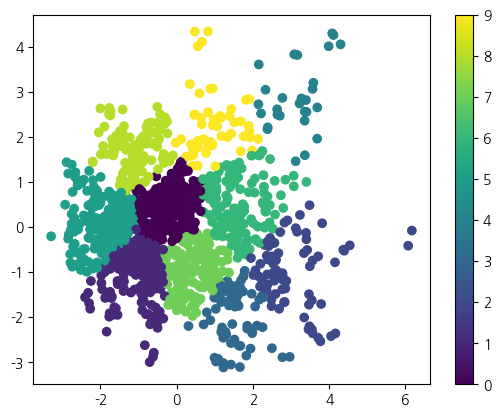

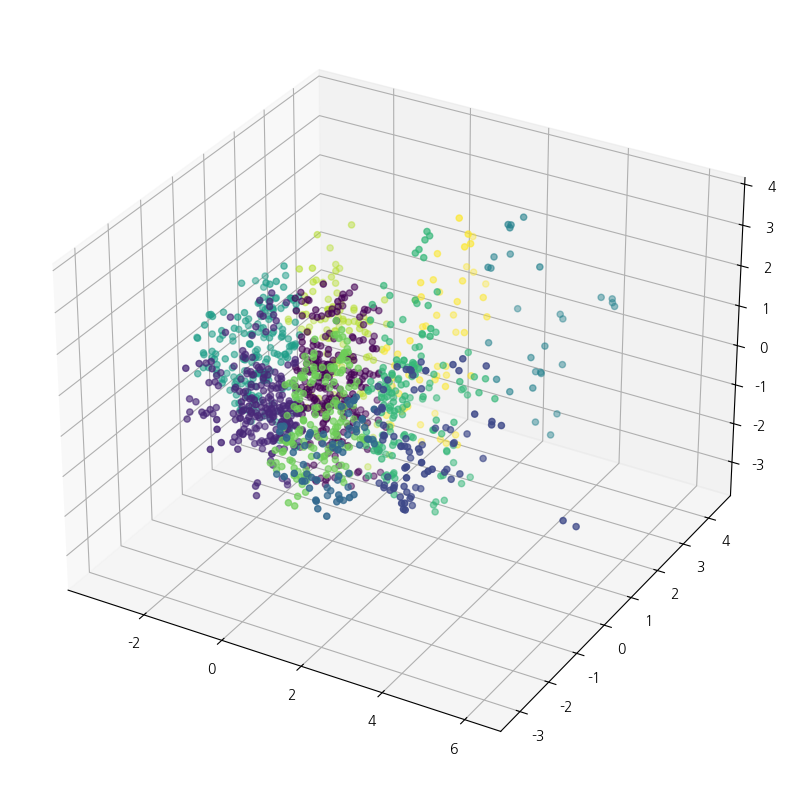

In [942]:
# 2d 시각화
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], c=selected_df['cluster'], cmap='viridis')
plt.colorbar()
plt.show()


# 3d 시각화
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], c=selected_df['cluster'], cmap='viridis')
plt.show()

=== 클러스터별 평균 통계 ===


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율
cluster,,,,,,,,,
0,4819653.02,0.28,0.29,3.05,0.56,4.775723e+09,23970.16,0.0,0.0
1,4926877.52,0.27,0.30,2.86,0.58,3.310179e+09,18532.17,0.0,0.0
2,7637015.76,0.43,0.47,2.75,0.56,6.823853e+09,24033.05,0.0,0.0
3,6829389.97,0.39,0.44,2.52,0.57,4.961857e+09,18832.88,0.0,0.0
4,6348257.24,0.36,0.40,3.89,0.51,8.563297e+09,32421.92,0.0,0.0
5,3112735.65,0.24,0.25,3.23,0.58,2.774483e+09,20124.12,0.0,0.0
6,6359830.21,0.33,0.37,3.10,0.55,6.418578e+09,25867.19,0.0,0.0
7,6605318.02,0.32,0.36,2.94,0.57,4.482716e+09,20137.39,0.0,0.0
8,2970505.90,0.23,0.23,3.35,0.56,4.679664e+09,27137.72,0.0,0.0



=== 클러스터별 샘플 데이터 (원래 스케일) ===

클러스터 8의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster,cluster3
590,3204294,0.261709,0.305490,3.190740,11710590,0.540595,3.765760e+09,24579.669205,0.0,0.0,8,5
62,4587586,0.169775,0.215777,2.871770,11470550,0.572271,7.192846e+09,39016.090571,0.0,0.0,8,7
580,4907868,0.261321,0.246228,3.818566,11710520,0.570726,4.331451e+09,30573.223034,0.0,0.0,8,5
302,4713570,0.216116,0.193400,2.978926,11170630,0.548581,5.677729e+09,35034.659023,0.0,0.0,8,7
1331,4933329,0.258945,0.243433,3.883779,11710520,0.567306,3.953756e+09,28451.346254,0.0,0.0,8,5
915,3223815,0.267595,0.180100,3.904153,11410520,0.548513,2.731277e+09,22187.762506,0.0,0.0,8,5
1413,4529722,0.213111,0.200811,2.781571,11170630,0.547359,4.901578e+09,33281.095359,0.0,0.0,8,7
573,3425996,0.286845,0.259167,3.091172,11680690,0.551269,5.035889e+09,26489.327925,0.0,0.0,8,7
1021,3137012,0.257350,0.204450,3.190824,11560670,0.560573,4.511793e+09,34160.064528,0.0,0.0,8,7
826,1033004,0.235138,0.143181,4.247205,11410690,0.543400,5.166560e+09,19959.474508,0.0,0.0,8,5



클러스터 5의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster,cluster3
1655,1173893,0.251880,0.236357,3.305618,11545690,0.570344,2.118035e+09,21595.105464,0.0,0.0,5,5
1572,3667626,0.257107,0.208326,2.779389,11410660,0.580232,4.732634e+09,27207.138261,0.0,0.0,5,7
872,3154063,0.231916,0.252310,3.364318,11320522,0.570839,1.705328e+09,16011.355318,0.0,0.0,5,9
307,1806906,0.274244,0.287954,2.714247,11170690,0.547710,1.579722e+09,25428.325813,0.0,0.0,5,5
434,4267464,0.201870,0.225144,2.858281,11470630,0.573378,4.649358e+09,24471.595325,0.0,0.0,5,1
242,704480,0.270479,0.325663,2.989890,11710720,0.537120,2.245161e+09,15251.517125,0.0,0.0,5,9
1602,3339761,0.210741,0.266479,2.887823,11470590,0.594099,3.031091e+09,20420.391472,0.0,0.0,5,1
991,5284846,0.218296,0.211510,2.876316,11530730,0.586591,3.550863e+09,20575.589328,0.0,0.0,5,1
97,1925041,0.272850,0.209392,3.932341,11530520,0.562676,2.844013e+09,18107.466330,0.0,0.0,5,5
787,2648383,0.245711,0.270352,3.305076,11350612,0.576152,9.698987e+08,12622.807714,0.0,0.0,5,9



클러스터 0의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster,cluster3
1174,1977182,0.307802,0.317427,3.560267,11140635,0.544608,5.781749e+09,22871.948195,0.0,0.0,0,3
1144,6690800,0.288123,0.282640,2.667813,11740660,0.560120,4.504358e+09,25521.805380,0.0,0.0,0,7
1252,6843788,0.276245,0.290620,2.689111,11260620,0.572168,5.687543e+09,32640.200930,0.0,0.0,0,7
1004,5468492,0.288638,0.228116,2.914895,11545670,0.564077,5.870224e+09,23404.205275,0.0,0.0,0,7
1127,2277930,0.254683,0.288390,3.347422,11710690,0.569397,5.015792e+09,19906.337701,0.0,0.0,0,5
27,7077860,0.211480,0.321509,2.097331,11380690,0.577695,2.894306e+09,34350.596971,0.0,0.0,0,7
402,4173211,0.266775,0.226530,2.196216,11305645,0.574886,6.958073e+09,23050.644015,0.0,0.0,0,7
333,5895296,0.211431,0.274586,3.207754,11215810,0.566017,5.525091e+09,25015.417044,0.0,0.0,0,7
864,3948848,0.268690,0.220353,2.085714,11305645,0.573343,8.274480e+09,24102.856256,0.0,0.0,0,7
954,2763107,0.265565,0.291116,2.997444,11470600,0.550810,3.160471e+09,22962.533721,0.0,0.0,0,5



클러스터 7의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster,cluster3
1558,10995979,0.271524,0.324859,2.966453,11380625,0.586202,3.130458e+09,20541.545991,0.0,0.0,7,8
1689,3600333,0.325981,0.426575,2.830703,11590670,0.571605,3.149368e+09,17263.653466,0.0,0.0,7,3
1469,9677599,0.315943,0.294350,2.624160,11260565,0.588848,6.051450e+09,18027.927984,0.0,0.0,7,8
827,6467599,0.356113,0.407051,3.121158,11410700,0.559111,3.678310e+09,18179.170766,0.0,0.0,7,3
983,6064435,0.290427,0.407257,2.667994,11530510,0.545600,2.897947e+09,22499.736753,0.0,0.0,7,3
995,4054068,0.341853,0.426227,2.796073,11530770,0.586294,5.876598e+09,15918.024791,0.0,0.0,7,8
1212,3290351,0.376152,0.373468,3.249450,11200790,0.560008,5.616143e+09,18543.275768,0.0,0.0,7,3
1246,6104342,0.275231,0.314559,2.967542,11260570,0.582040,6.541361e+09,20759.230137,0.0,0.0,7,8
740,5589332,0.340960,0.357287,3.130302,11290610,0.564964,3.041288e+09,20827.030529,0.0,0.0,7,3
1691,3528957,0.390874,0.392763,3.199028,11620525,0.549939,2.812175e+09,18816.713765,0.0,0.0,7,3



클러스터 2의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster,cluster3
1587,4707098,0.476060,0.584364,2.466281,11440680,0.532543,6.696282e+09,26959.129952,0.0,0.0,2,2
1462,5912753,0.470849,0.481265,2.745870,11230720,0.557931,4.339879e+09,22161.184698,0.0,0.0,2,2
938,4642709,0.471552,0.591529,2.433065,11440680,0.532253,7.382246e+09,28949.434401,0.0,0.0,2,2
793,10533149,0.284353,0.444540,2.429221,11350640,0.552808,5.642270e+09,24331.697163,0.0,0.0,2,4
351,5635452,0.444589,0.488312,2.668927,11230720,0.554440,3.869011e+09,24826.018368,0.0,0.0,2,2
51,4716787,0.477535,0.580356,2.466062,11440680,0.536332,7.539022e+09,29470.998991,0.0,0.0,2,2
327,6601908,0.469469,0.453063,3.221317,11215730,0.549089,4.139927e+09,25995.288933,0.0,0.0,2,2
46,7603223,0.459151,0.470164,3.426934,11440600,0.533392,6.773456e+09,21219.278012,0.0,0.0,2,2
600,8266108,0.369319,0.432219,2.399253,11710650,0.580470,8.224881e+09,27180.964939,0.0,0.0,2,4
586,6314479,0.427504,0.525739,2.397576,11710562,0.569830,8.382548e+09,28597.224426,0.0,0.0,2,2



클러스터 1의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster,cluster3
404,3689676,0.274575,0.352005,3.035509,11320511,0.559390,3.950064e+09,16821.298936,0.0,0.0,1,3
14,5847532,0.276142,0.235915,2.819671,11380530,0.581345,5.109580e+09,20185.171727,0.0,0.0,1,1
940,5954469,0.323288,0.302706,2.805727,11440700,0.584707,3.933238e+09,18643.127393,0.0,0.0,1,8
1425,4599491,0.277171,0.322952,3.606044,11200570,0.580729,1.705512e+09,17817.928371,0.0,0.0,1,9
1180,3897620,0.322290,0.314739,3.187910,11170510,0.576763,3.607223e+09,16526.764483,0.0,0.0,1,9
1002,4609546,0.327153,0.265522,2.706877,11545630,0.575205,4.505664e+09,19950.078533,0.0,0.0,1,1
424,5679498,0.234218,0.237622,2.657817,11470540,0.593544,2.998694e+09,21021.700764,0.0,0.0,1,1
1599,3988140,0.252114,0.228494,2.360022,11470560,0.584490,4.442203e+09,21007.621660,0.0,0.0,1,1
114,3543640,0.294200,0.302823,2.782823,11545620,0.590225,4.315212e+09,19508.138543,0.0,0.0,1,1
742,5984812,0.277165,0.249653,3.408143,11290630,0.599341,2.607852e+09,21233.181161,0.0,0.0,1,1



클러스터 6의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster,cluster3
1177,3686931,0.283051,0.340530,2.879711,11140665,0.537411,8.310722e+09,23485.173401,0.0,0.0,6,4
396,7160604,0.320882,0.346341,2.285729,11305595,0.557573,6.742787e+09,28086.155670,0.0,0.0,6,4
593,8042825,0.314545,0.358700,3.525519,11710620,0.551289,5.113940e+09,26548.086131,0.0,0.0,6,4
870,3945245,0.269336,0.341116,3.077619,11320515,0.548094,8.113368e+09,21588.196004,0.0,0.0,6,4
1254,4263862,0.269601,0.330741,3.144703,11320515,0.540792,8.325847e+09,22847.176614,0.0,0.0,6,4
228,6981836,0.370490,0.378704,2.959095,11710600,0.563808,5.455405e+09,25797.765797,0.0,0.0,6,4
1615,7126061,0.308736,0.334298,3.134856,11500535,0.542209,4.580049e+09,24863.649372,0.0,0.0,6,4
126,8487352,0.405394,0.466427,4.003402,11560560,0.542489,4.680884e+09,21266.748166,0.0,0.0,6,6
1424,5898939,0.369138,0.370241,3.295106,11200560,0.540303,5.885019e+09,26125.748509,0.0,0.0,6,4
1178,5456634,0.376390,0.297458,2.592402,11140670,0.549711,7.531970e+09,27906.121492,0.0,0.0,6,4



클러스터 3의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster,cluster3
1051,4516657,0.361187,0.505665,2.610628,11620630,0.574993,5.716175e+09,19708.013234,0.0,0.0,3,2
1239,4248164,0.429031,0.436836,2.698518,11230730,0.571961,3.565460e+09,24733.946239,0.0,0.0,3,2
343,10948030,0.341220,0.424120,2.275094,11230560,0.557593,4.148977e+09,19507.982564,0.0,0.0,3,2
353,8989006,0.471355,0.537720,2.914228,11230740,0.550052,4.126257e+09,12935.669541,0.0,0.0,3,2
1588,6926246,0.413891,0.388299,2.405475,11440690,0.588463,4.611851e+09,18976.382152,0.0,0.0,3,8
1224,8643474,0.372408,0.486432,2.378034,11215847,0.568503,4.267691e+09,20651.491263,0.0,0.0,3,2
1055,7421992,0.437809,0.400221,2.769436,11620685,0.583418,3.608291e+09,15985.199405,0.0,0.0,3,2
668,2978336,0.385542,0.508146,2.228511,11170660,0.559584,4.412640e+09,25738.386287,0.0,0.0,3,2
1658,6783305,0.324753,0.472371,2.028569,11560515,0.572856,6.922327e+09,12869.691404,0.0,0.0,3,2
1045,7109632,0.450998,0.431909,2.758511,11620575,0.579699,5.286944e+09,20157.082565,0.0,0.0,3,2



클러스터 9의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster,cluster3
945,4872416,0.230296,0.321909,2.686451,11470510,0.513869,5.799760e+09,26503.590652,0.0,0.0,9,7
255,6011262,0.277162,0.341261,3.149172,11740640,0.540857,4.064790e+09,38975.085634,0.0,0.0,9,0
830,7577861,0.309350,0.327130,4.489789,11440555,0.535264,4.760074e+09,24314.454514,0.0,0.0,9,6
1304,6248929,0.283070,0.308551,4.009928,11650621,0.540334,5.544563e+09,30361.115085,0.0,0.0,9,0
1578,7902508,0.302827,0.304130,4.248936,11440555,0.532524,4.681064e+09,24407.457675,0.0,0.0,9,6
1321,3962722,0.219576,0.286283,4.112588,11680656,0.517315,7.702590e+09,33992.145988,0.0,0.0,9,0
42,7481563,0.313312,0.311707,4.541736,11440555,0.534864,4.885901e+09,26760.312921,0.0,0.0,9,6
1142,5778800,0.273083,0.342545,3.037297,11740640,0.543136,4.403674e+09,37508.530940,0.0,0.0,9,0
1580,4368209,0.338673,0.368667,3.909975,11440585,0.538563,6.906468e+09,36923.351990,0.0,0.0,9,0
597,2852529,0.357404,0.470047,3.830845,11710642,0.504337,3.953797e+09,25923.668378,0.0,0.0,9,6



클러스터 4의 샘플:


,총_유동인구_수,청년층_유동인구_비율,청년_매출_비율,주말_매출_비율,행정동_코드,야간유동인구비율,점포당_월매출액,객단가,개업_율,프랜차이즈_점포_비율,cluster,cluster3
187,4361990,0.319062,0.348138,4.248730,11650600,0.536045,9.863192e+09,33881.722406,0.0,0.0,4,0
648,5592770,0.380390,0.408276,3.445357,11140615,0.536441,1.124007e+10,30561.066729,0.0,0.0,4,0
543,6210521,0.327232,0.380942,3.890790,11650540,0.505825,8.815403e+09,37229.758724,0.0,0.0,4,0
128,9249193,0.336303,0.422188,4.505827,11560605,0.494383,1.052881e+10,35006.864246,0.0,0.0,4,0
1090,10904498,0.289174,0.298819,2.978444,11680630,0.493290,1.180763e+10,27513.568069,0.0,0.0,4,0
1067,6231845,0.324580,0.383400,3.960512,11650540,0.507567,8.606476e+09,37361.234955,0.0,0.0,4,0
1623,3191124,0.395239,0.483612,4.289547,11500603,0.494838,4.489570e+09,32086.610121,0.0,0.0,4,6
1069,6698873,0.372023,0.377958,3.526940,11650560,0.531520,8.786354e+09,37550.124801,0.0,0.0,4,0
1296,6803734,0.368970,0.381419,3.596050,11650560,0.534084,9.042261e+09,38361.224833,0.0,0.0,4,0
1664,9414441,0.340020,0.385192,4.612108,11560605,0.494607,1.019973e+10,35855.292551,0.0,0.0,4,0



=== 클러스터별 구 분포 (상위 3개) ===

클러스터 8의 주요 구:
- 양천구: 20개 행정동
- 강동구: 14개 행정동
- 송파구: 13개 행정동

클러스터 5의 주요 구:
- 노원구: 21개 행정동
- 양천구: 20개 행정동
- 구로구: 16개 행정동

클러스터 0의 주요 구:
- 강서구: 28개 행정동
- 송파구: 17개 행정동
- 강동구: 17개 행정동

클러스터 7의 주요 구:
- 중랑구: 21개 행정동
- 광진구: 17개 행정동
- 성북구: 15개 행정동

클러스터 2의 주요 구:
- 관악구: 12개 행정동
- 송파구: 11개 행정동
- 마포구: 8개 행정동

클러스터 1의 주요 구:
- 중랑구: 22개 행정동
- 은평구: 21개 행정동
- 노원구: 17개 행정동

클러스터 6의 주요 구:
- 송파구: 21개 행정동
- 동작구: 18개 행정동
- 성동구: 17개 행정동

클러스터 3의 주요 구:
- 관악구: 24개 행정동
- 광진구: 10개 행정동
- 동대문구: 10개 행정동

클러스터 9의 주요 구:
- 마포구: 11개 행정동
- 송파구: 7개 행정동
- 서초구: 6개 행정동

클러스터 4의 주요 구:
- 서초구: 10개 행정동
- 영등포구: 7개 행정동
- 강서구: 4개 행정동


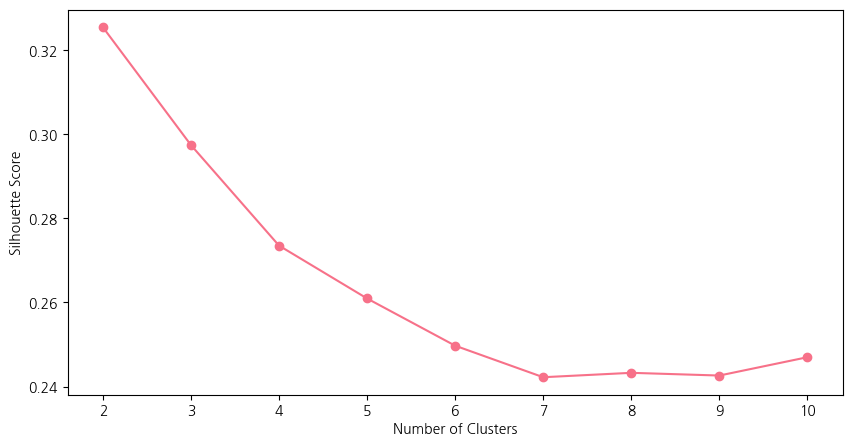

최적의 클러스터 수: 2


In [943]:
# 클러스터별 통계 분석
cluster_stats = selected_df.groupby('cluster').agg({
    "총_유동인구_수": 'mean',
    "청년층_유동인구_비율": 'mean',
    "청년_매출_비율": 'mean',
    "주말_매출_비율": 'mean',
    "야간유동인구비율": 'mean',
    "점포당_월매출액": 'mean',
    "객단가": 'mean',
    "개업_율": 'mean',
    "프랜차이즈_점포_비율": 'mean',
}).round(2)

# 각 클러스터별 샘플 데이터 확인 (각 클러스터에서 3개씩)
cluster_samples = {}
for cluster in selected_df['cluster'].unique():
    cluster_samples[cluster] = selected_df[selected_df['cluster'] == cluster].sample(10)

# 결과 출력
print("=== 클러스터별 평균 통계 ===")
display(cluster_stats)

print("\n=== 클러스터별 샘플 데이터 (원래 스케일) ===")
for cluster, samples in cluster_samples.items():
    print(f"\n클러스터 {cluster}의 샘플:")
    display(samples)

# 각 클러스터별 구 분포 분석
print("\n=== 클러스터별 구 분포 (상위 3개) ===")
for cluster in selected_df['cluster'].unique():
    cluster_data = selected_df[selected_df['cluster'] == cluster]
    # 행정동 코드의 앞 5자리가 구 코드
    gu_counts = cluster_data['행정동_코드'].astype(str).str[:5].value_counts()
    
    print(f"\n클러스터 {cluster}의 주요 구:")
    for gu_code, count in gu_counts.head(3).items():
        gu_name = seoul_gu_code_map.get(gu_code, '알 수 없음')
        print(f"- {gu_name}: {count}개 행정동")

#  실루엣 계수
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca3)
    labels = kmeans.labels_
    score = silhouette_score(X_pca3, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# 최적의 클러스터 수 찾기
best_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"최적의 클러스터 수: {best_k}")


=== 클러스터별 구 분포 (상위 3개) ===

클러스터 8의 주요 구:
- 양천구: 20개 행정동
- 강동구: 14개 행정동
- 송파구: 13개 행정동

클러스터 5의 주요 구:
- 노원구: 21개 행정동
- 양천구: 20개 행정동
- 구로구: 16개 행정동

클러스터 0의 주요 구:
- 강서구: 28개 행정동
- 송파구: 17개 행정동
- 강동구: 17개 행정동

클러스터 7의 주요 구:
- 중랑구: 21개 행정동
- 광진구: 17개 행정동
- 성북구: 15개 행정동

클러스터 2의 주요 구:
- 관악구: 12개 행정동
- 송파구: 11개 행정동
- 마포구: 8개 행정동

클러스터 1의 주요 구:
- 중랑구: 22개 행정동
- 은평구: 21개 행정동
- 노원구: 17개 행정동

클러스터 6의 주요 구:
- 송파구: 21개 행정동
- 동작구: 18개 행정동
- 성동구: 17개 행정동

클러스터 3의 주요 구:
- 관악구: 24개 행정동
- 광진구: 10개 행정동
- 동대문구: 10개 행정동

클러스터 9의 주요 구:
- 마포구: 11개 행정동
- 송파구: 7개 행정동
- 서초구: 6개 행정동

클러스터 4의 주요 구:
- 서초구: 10개 행정동
- 영등포구: 7개 행정동
- 강서구: 4개 행정동


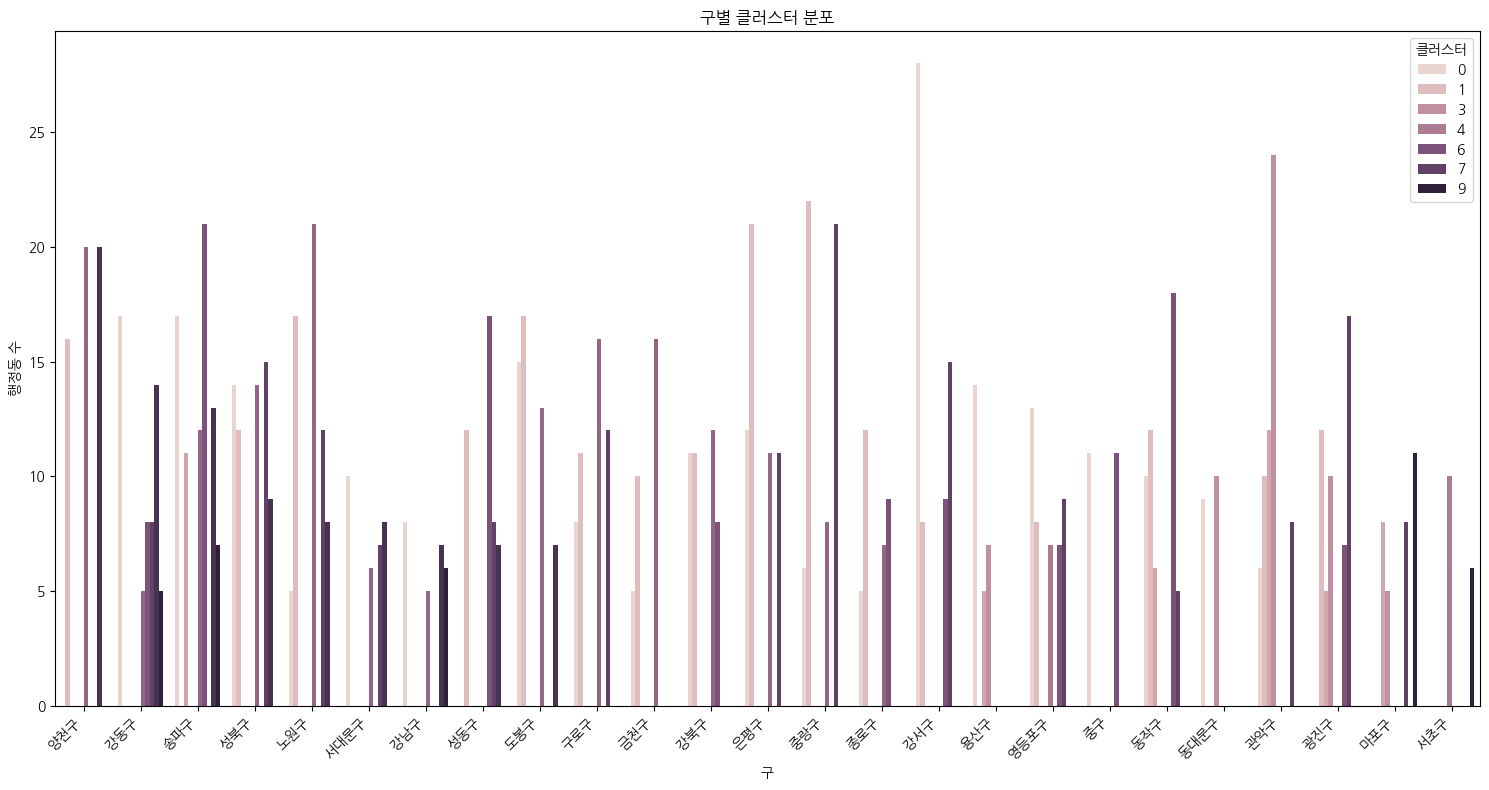

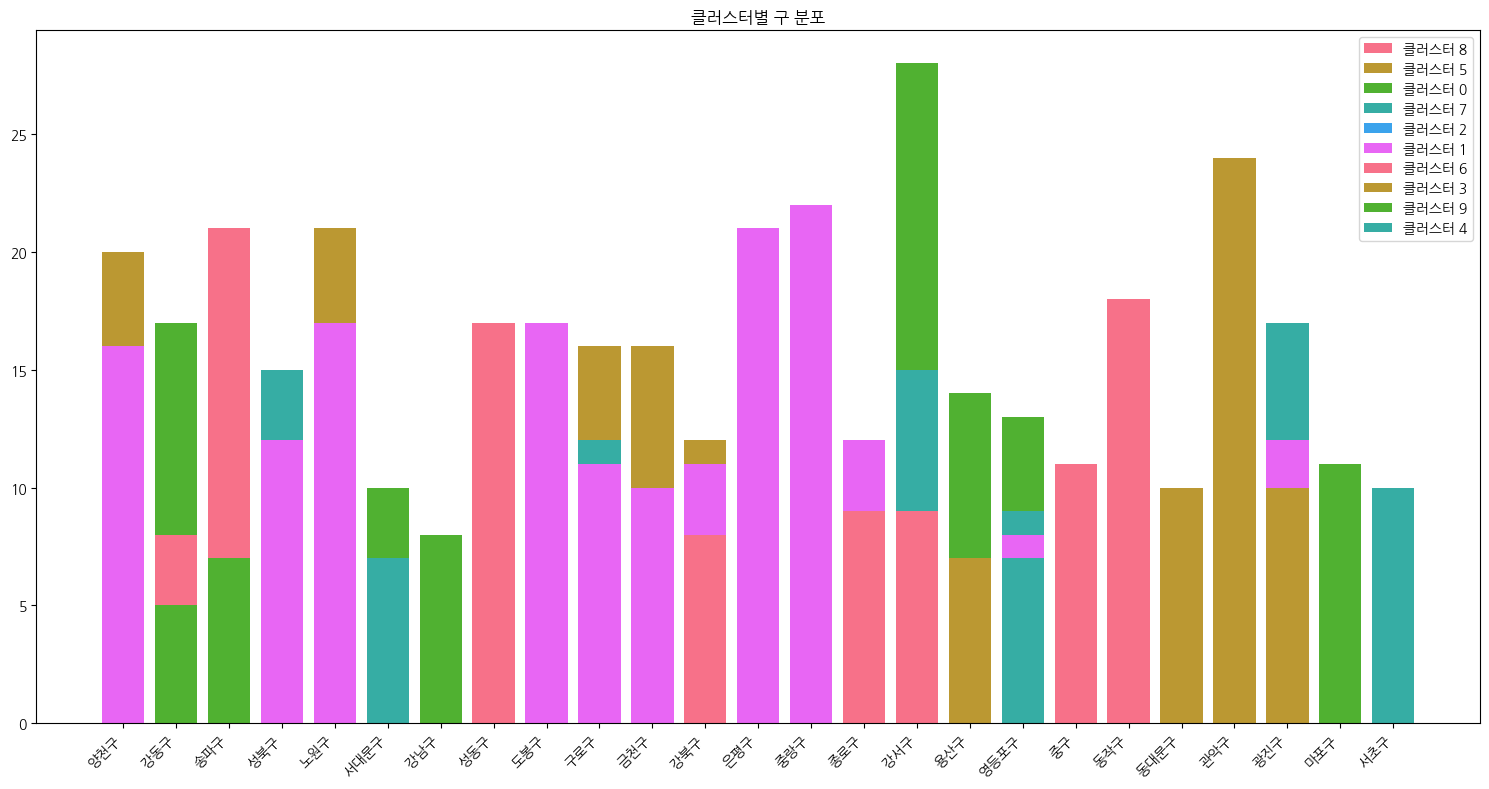

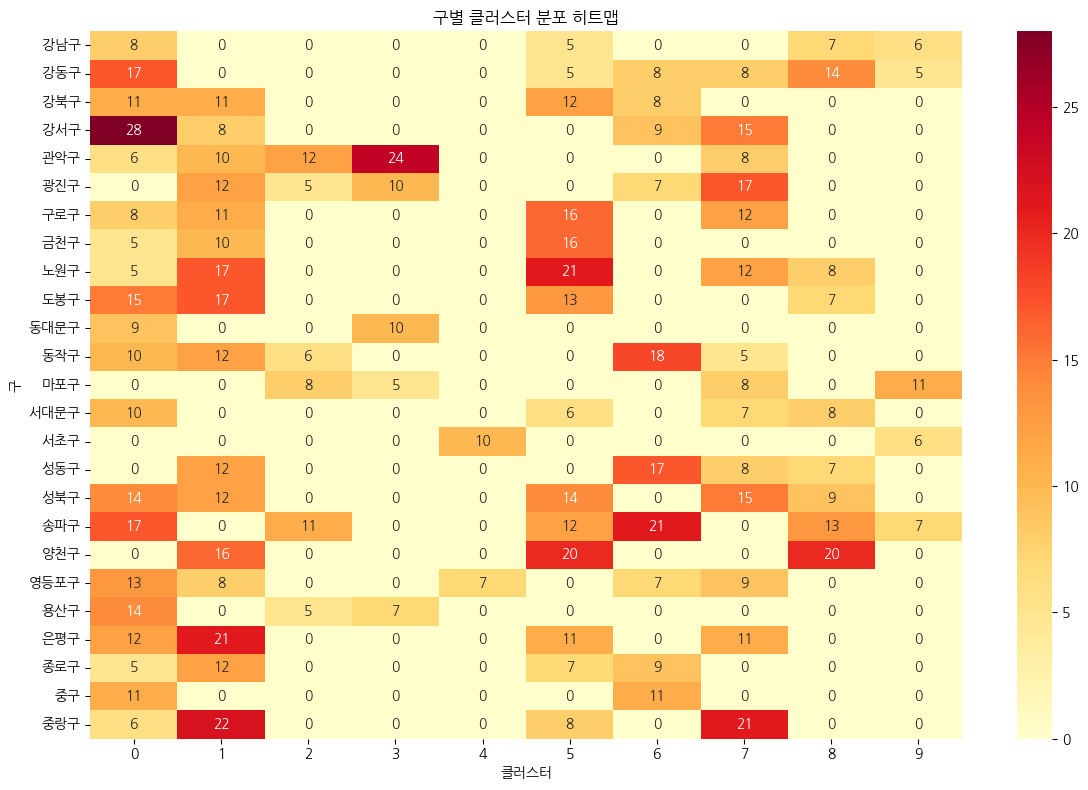

In [944]:
# 클러스터별 구 분포 분석
print("\n=== 클러스터별 구 분포 (상위 3개) ===")
for cluster in selected_df['cluster'].unique():
    cluster_data = selected_df[selected_df['cluster'] == cluster]
    # 행정동 코드의 앞 5자리가 구 코드
    gu_counts = cluster_data['행정동_코드'].astype(str).str[:5].value_counts()
    
    print(f"\n클러스터 {cluster}의 주요 구:")
    for gu_code, count in gu_counts.head(3).items():
        gu_name = seoul_gu_code_map.get(gu_code, '알 수 없음')
        print(f"- {gu_name}: {count}개 행정동")

# 각 클러스터별 구 분포 분석 및 필터링
cluster_gu_counts = {}
for cluster in selected_df['cluster'].unique():
    cluster_data = selected_df[selected_df['cluster'] == cluster]
    gu_counts = cluster_data['행정동_코드'].astype(str).str[:5].value_counts()
    
    # 최소 5개 이상인 구만 선택
    significant_gu = gu_counts[gu_counts >= 5]
    cluster_gu_counts[cluster] = significant_gu

# 각 구별 클러스터 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 구별 클러스터 분포 데이터 생성
gu_cluster_data = []
for cluster, gu_counts in cluster_gu_counts.items():
    for gu_code, count in gu_counts.items():
        gu_name = seoul_gu_code_map.get(gu_code, '알 수 없음')
        gu_cluster_data.append({
            '구': gu_name,
            '클러스터': cluster,
            '행정동 수': count
        })

gu_cluster_df = pd.DataFrame(gu_cluster_data)

# 시각화
plt.figure(figsize=(15, 8))
sns.barplot(data=gu_cluster_df, x='구', y='행정동 수', hue='클러스터')
plt.xticks(rotation=45, ha='right')
plt.title('구별 클러스터 분포')
plt.tight_layout()
plt.show()

# 각 클러스터별 주요 구 시각화
plt.figure(figsize=(15, 8))
for cluster in selected_df['cluster'].unique():
    cluster_data = gu_cluster_df[gu_cluster_df['클러스터'] == cluster]
    plt.bar(cluster_data['구'], cluster_data['행정동 수'], label=f'클러스터 {cluster}')

plt.xticks(rotation=45, ha='right')
plt.title('클러스터별 구 분포')
plt.legend()
plt.tight_layout()
plt.show()

# 히트맵으로 시각화
pivot_df = gu_cluster_df.pivot(index='구', columns='클러스터', values='행정동 수').fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='YlOrRd', fmt='.0f')
plt.title('구별 클러스터 분포 히트맵')
plt.tight_layout()
plt.show()

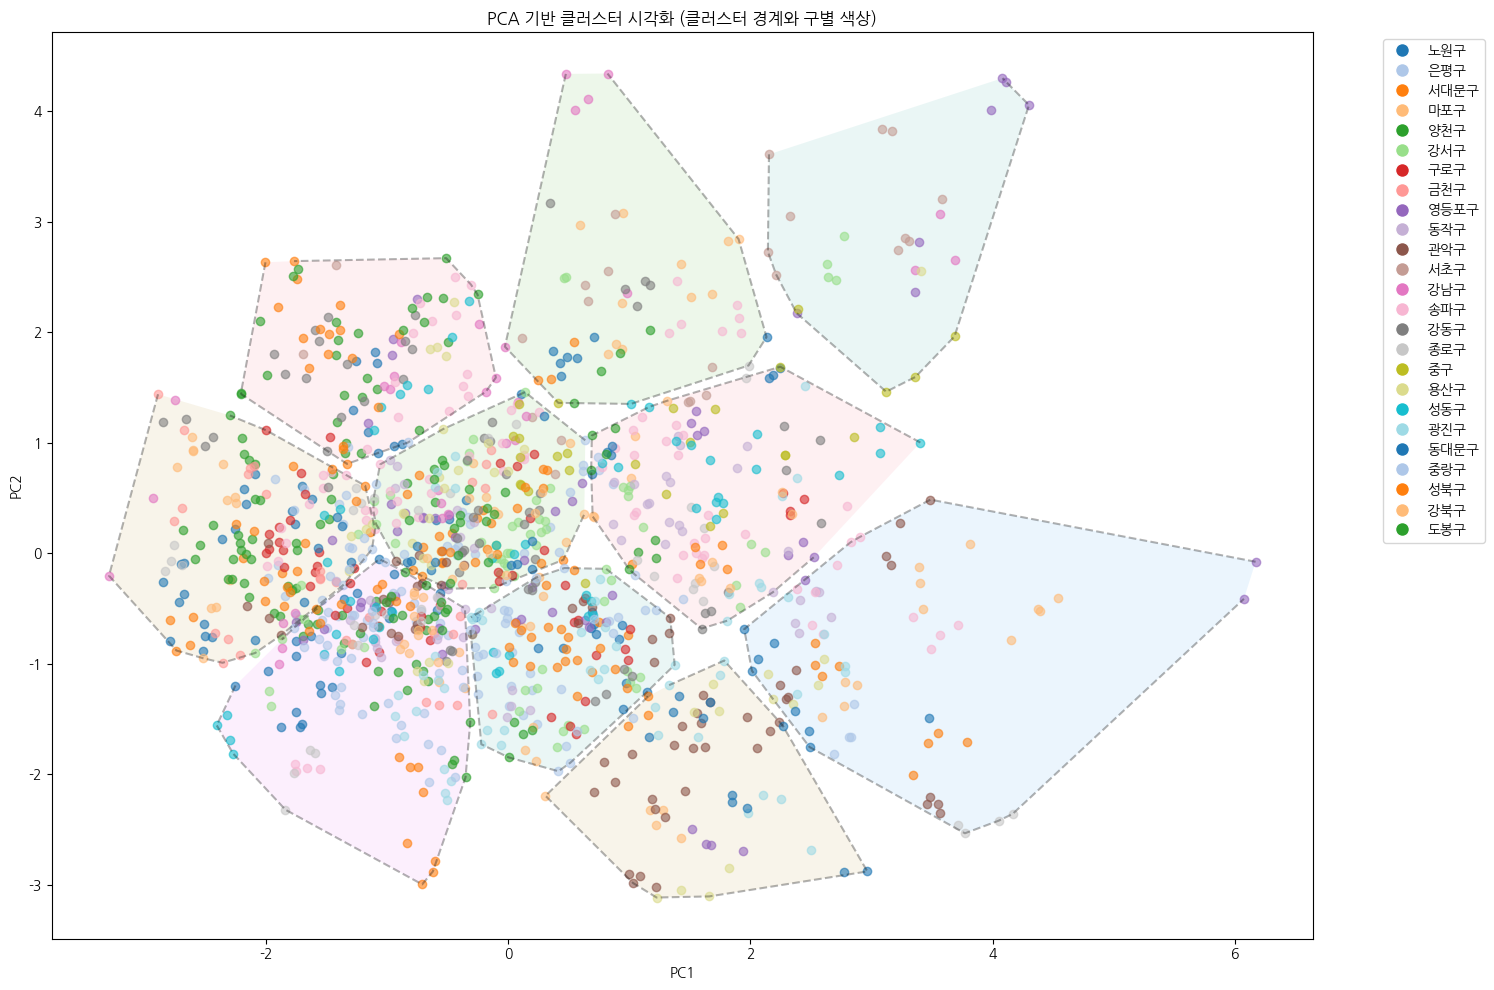

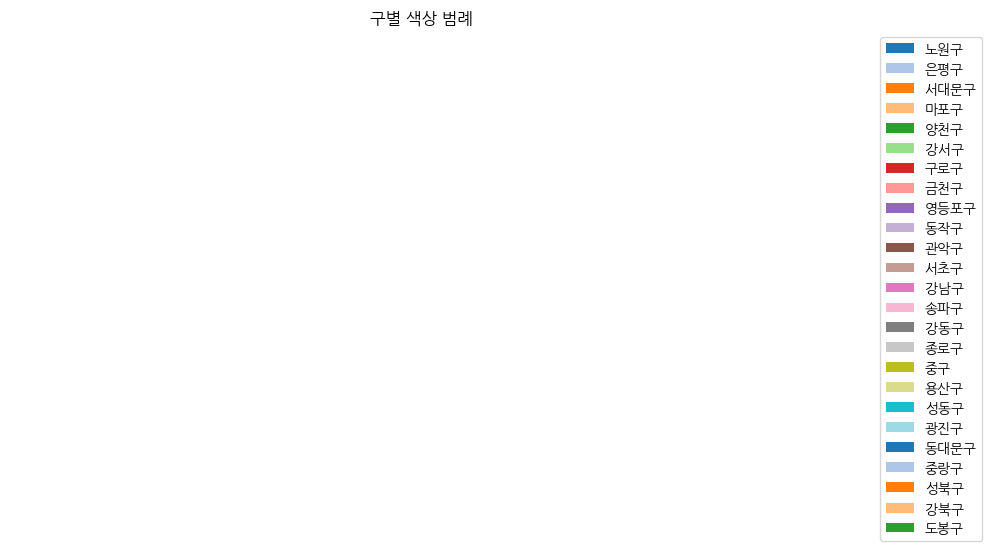

In [945]:
# selected_df = 

# PCA 기반 클러스터 시각화 (클러스터 경계와 구별 색상)
plt.figure(figsize=(15, 10))

# 구별 색상 매핑 생성
unique_gu_codes = selected_df['행정동_코드'].astype(str).str[:5].unique()
gu_colors = {gu_code: plt.cm.tab20(i % 20) for i, gu_code in enumerate(unique_gu_codes)}

# 각 클러스터별로 플롯
for cluster in selected_df['cluster'].unique():
    cluster_mask = selected_df['cluster'] == cluster
    
    # 클러스터의 경계를 표시하기 위한 convex hull 계산
    cluster_points = X_pca2[cluster_mask]
    if len(cluster_points) > 2:  # 최소 3개의 점이 필요
        from scipy.spatial import ConvexHull
        hull = ConvexHull(cluster_points)
        plt.plot(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], 'k--', alpha=0.3)
        plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], alpha=0.1)
    
    # 각 구별로 다른 색상으로 플롯
    for gu_code in unique_gu_codes:
        gu_mask = selected_df['행정동_코드'].astype(str).str[:5] == gu_code
        combined_mask = cluster_mask & gu_mask
        
        if combined_mask.any():
            plt.scatter(
                X_pca2[combined_mask, 0],
                X_pca2[combined_mask, 1],
                c=[gu_colors[gu_code]],
                label=f'클러스터 {cluster} - {seoul_gu_code_map.get(gu_code, "알 수 없음")}',
                alpha=0.6
            )

# 범례 추가 (구별 색상)
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=gu_colors[gu_code], 
                     markersize=10, 
                     label=seoul_gu_code_map.get(gu_code, "알 수 없음"))
          for gu_code in unique_gu_codes]

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA 기반 클러스터 시각화 (클러스터 경계와 구별 색상)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

# 구별 색상 범례를 별도로 표시
plt.figure(figsize=(10, 6))
for gu_code, color in gu_colors.items():
    plt.bar(0, 0, color=color, label=seoul_gu_code_map.get(gu_code, "알 수 없음"))
plt.axis('off')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('구별 색상 범례')
plt.tight_layout()
plt.show()

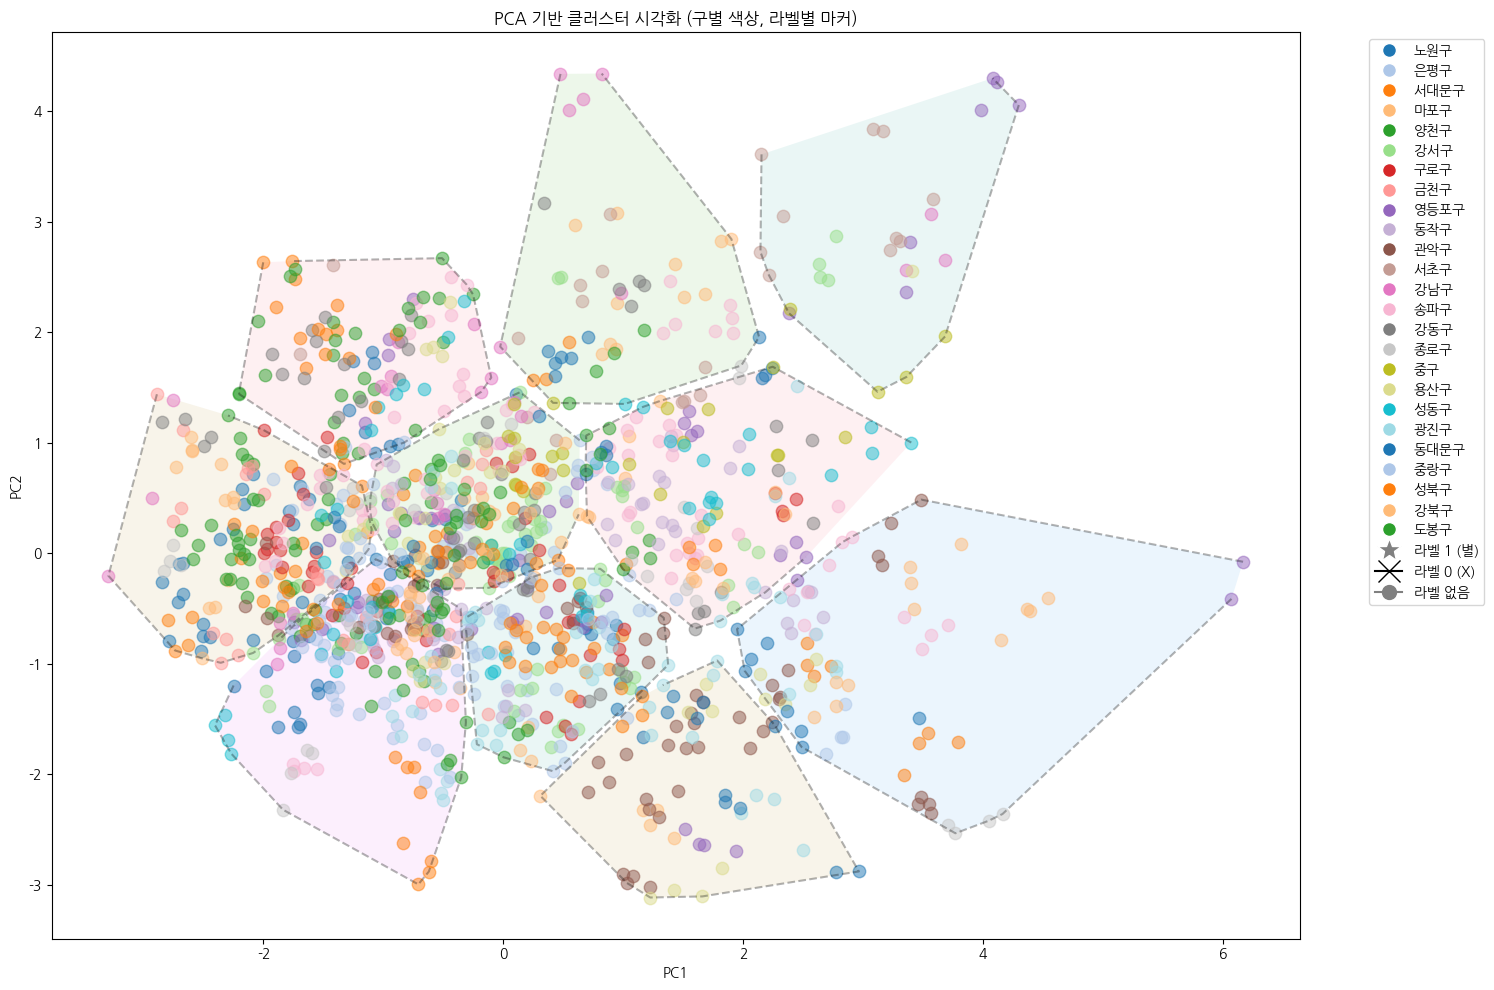

In [946]:
import pandas as pd
from scipy.spatial import ConvexHull

# label.xlsx에서 라벨 정보 읽기
label_df = pd.read_excel('label.xlsx')

label_map = dict(zip(label_df['행정동_코드'], label_df['라벨']))

# selected_df에 라벨 컬럼 추가 (없으면 NaN)
selected_df['라벨'] = selected_df['행정동_코드'].map(label_map)

plt.figure(figsize=(15, 10))

unique_gu_codes = selected_df['행정동_코드'].astype(str).str[:5].unique()
gu_colors = {gu_code: plt.cm.tab20(i % 20) for i, gu_code in enumerate(unique_gu_codes)}

for cluster in selected_df['cluster'].unique():
    cluster_mask = selected_df['cluster'] == cluster
    cluster_points = X_pca2[cluster_mask]
    if len(cluster_points) > 2:
        hull = ConvexHull(cluster_points)
        plt.plot(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], 'k--', alpha=0.3)
        plt.fill(cluster_points[hull.vertices, 0], cluster_points[hull.vertices, 1], alpha=0.1)
    
    for gu_code in unique_gu_codes:
        gu_mask = selected_df['행정동_코드'].astype(str).str[:5] == gu_code
        combined_mask = cluster_mask & gu_mask
        # 라벨별로 마커 다르게
        star_mask = combined_mask & (selected_df['라벨'] == 1)
        x_mask = combined_mask & (selected_df['라벨'] == 0)
        none_mask = combined_mask & (selected_df['라벨'].isna())
        if star_mask.any():
            plt.scatter(
                X_pca2[star_mask, 0],
                X_pca2[star_mask, 1],
                c=[gu_colors[gu_code]],
                marker='*',
                s=600,                # 훨씬 크게!
                edgecolor='black',
                linewidths=2.5,       # 두꺼운 테두리
                alpha=1.0,
                zorder=10,
                label=None
            )
        if x_mask.any():
            plt.scatter(
                X_pca2[x_mask, 0],
                X_pca2[x_mask, 1],
                c=[gu_colors[gu_code]],
                marker='x',
                s=400,                # 훨씬 크게!
                edgecolor='black',
                linewidths=4,         # 두꺼운 테두리
                alpha=1.0,
                zorder=9,
                label=None
            )
        if none_mask.any():
            plt.scatter(
                X_pca2[none_mask, 0],
                X_pca2[none_mask, 1],
                c=[gu_colors[gu_code]],
                marker='o',
                s=80,
                alpha=0.5,
                zorder=1,
                label=None
            )

# 범례 추가 (구별 색상)
handles = [plt.Line2D([0], [0], marker='o', color='w', 
                     markerfacecolor=gu_colors[gu_code], 
                     markersize=10, 
                     label=seoul_gu_code_map.get(gu_code, "알 수 없음"))
          for gu_code in unique_gu_codes]

# 마커별 범례 추가
handles += [
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='gray', markersize=18, label='라벨 1 (별)'),
    plt.Line2D([0], [0], marker='x', color='black', markerfacecolor='black', markersize=16, label='라벨 0 (X)'),
    plt.Line2D([0], [0], marker='o', color='gray', markerfacecolor='gray', markersize=10, label='라벨 없음')
]

plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA 기반 클러스터 시각화 (구별 색상, 라벨별 마커)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()

In [947]:
print(label_df['라벨'])

0      0
1      0
2      0
3      0
4      0
      ..
155    0
156    1
157    0
158    0
159    0
Name: 라벨, Length: 160, dtype: int64


In [948]:
print(selected_df['라벨'].value_counts(dropna=False))
print(selected_df[['행정동_코드', '라벨']].head(10))
# 두 데이터프레임의 행정동_코드 타입을 맞추세요!
selected_df['행정동_코드'] = selected_df['행정동_코드'].astype(str)
label_df['행정동_코드'] = label_df['행정동_코드'].astype(str)

# 다시 라벨 매핑
selected_df['라벨'] = selected_df['행정동_코드'].map(dict(zip(label_df['행정동_코드'], label_df['라벨'])))
print(selected_df['라벨'].value_counts(dropna=False))
labeled_df = selected_df[selected_df['라벨'].isin([0, 1])]
print(len(labeled_df))
print(labeled_df[['행정동_코드', '라벨']].head())

# 라벨이 있는 데이터만 추출
labeled_df = selected_df[selected_df['라벨'].isin([0, 1])]

# 각 라벨별로 클러스터 분포 출력
for label_value in [0.0, 1.0]:
    print(f"\n라벨 {label_value}인 데이터의 클러스터 분포:")
    label_cluster_counts = labeled_df[labeled_df['라벨'] == label_value]['cluster'].value_counts().sort_index()
    for cluster, count in label_cluster_counts.items():
        print(f"  클러스터 {cluster}: {count}개")

# 라벨이 있는 각 행정동의 클러스터 정보 출력
print("\n라벨이 있는 각 행정동의 클러스터 정보:")
for _, row in labeled_df.iterrows():
    print(f"행정동코드: {row['행정동_코드']}, 라벨: {row['라벨']}, 클러스터: {row['cluster']}")

라벨
NaN    1309
Name: count, dtype: int64
     행정동_코드  라벨
0  11350619 NaN
1  11350621 NaN
2  11350624 NaN
3  11350625 NaN
4  11350630 NaN
5  11350640 NaN
6  11350665 NaN
7  11350670 NaN
8  11350695 NaN
9  11350700 NaN
라벨
NaN    820
0.0    388
1.0    101
Name: count, dtype: int64
489
      행정동_코드   라벨
0   11350619  1.0
6   11350665  0.0
8   11350695  0.0
14  11380530  0.0
16  11380552  0.0

라벨 0.0인 데이터의 클러스터 분포:
  클러스터 0: 65개
  클러스터 1: 80개
  클러스터 2: 15개
  클러스터 3: 27개
  클러스터 4: 12개
  클러스터 5: 55개
  클러스터 6: 54개
  클러스터 7: 47개
  클러스터 8: 21개
  클러스터 9: 12개

라벨 1.0인 데이터의 클러스터 분포:
  클러스터 0: 18개
  클러스터 1: 15개
  클러스터 2: 14개
  클러스터 3: 12개
  클러스터 4: 4개
  클러스터 5: 7개
  클러스터 6: 14개
  클러스터 7: 8개
  클러스터 8: 7개
  클러스터 9: 2개

라벨이 있는 각 행정동의 클러스터 정보:
행정동코드: 11350619, 라벨: 1.0, 클러스터: 8
행정동코드: 11350665, 라벨: 0.0, 클러스터: 1
행정동코드: 11350695, 라벨: 0.0, 클러스터: 6
행정동코드: 11380530, 라벨: 0.0, 클러스터: 1
행정동코드: 11380552, 라벨: 0.0, 클러스터: 7
행정동코드: 11380560, 라벨: 0.0, 클러스터: 1
행정동코드: 11380570, 라벨: 0.0, 클러스터: 3
행정동코드: 11380600, 라벨: 0.0, 

In [949]:
# 클러스터별 1.0, 0.0 개수와 비율 출력
print("클러스터별 1.0/0.0 비율 (1.0 개수 / 0.0 개수):")
for cluster in sorted(labeled_df['cluster'].unique()):
    cluster_data = labeled_df[labeled_df['cluster'] == cluster]
    count_1 = (cluster_data['라벨'] == 1.0).sum()
    count_0 = (cluster_data['라벨'] == 0.0).sum()
    ratio = count_1 / count_0 if count_0 > 0 else float('inf')
    print(f"클러스터 {cluster}: 1.0 = {count_1}, 0.0 = {count_0}, 비율(1.0/0.0) = {ratio:.2f}")

클러스터별 1.0/0.0 비율 (1.0 개수 / 0.0 개수):
클러스터 0: 1.0 = 18, 0.0 = 65, 비율(1.0/0.0) = 0.28
클러스터 1: 1.0 = 15, 0.0 = 80, 비율(1.0/0.0) = 0.19
클러스터 2: 1.0 = 14, 0.0 = 15, 비율(1.0/0.0) = 0.93
클러스터 3: 1.0 = 12, 0.0 = 27, 비율(1.0/0.0) = 0.44
클러스터 4: 1.0 = 4, 0.0 = 12, 비율(1.0/0.0) = 0.33
클러스터 5: 1.0 = 7, 0.0 = 55, 비율(1.0/0.0) = 0.13
클러스터 6: 1.0 = 14, 0.0 = 54, 비율(1.0/0.0) = 0.26
클러스터 7: 1.0 = 8, 0.0 = 47, 비율(1.0/0.0) = 0.17
클러스터 8: 1.0 = 7, 0.0 = 21, 비율(1.0/0.0) = 0.33
클러스터 9: 1.0 = 2, 0.0 = 12, 비율(1.0/0.0) = 0.17


In [950]:
print(selected_df['라벨'].value_counts(dropna=False))
print(selected_df[['행정동_코드', '라벨']].head(10))
# 두 데이터프레임의 행정동_코드 타입을 맞추세요!
selected_df['행정동_코드'] = selected_df['행정동_코드'].astype(str)
label_df['행정동_코드'] = label_df['행정동_코드'].astype(str)

# 다시 라벨 매핑
selected_df['라벨'] = selected_df['행정동_코드'].map(dict(zip(label_df['행정동_코드'], label_df['라벨'])))
print(selected_df['라벨'].value_counts(dropna=False))
labeled_df = selected_df[selected_df['라벨'].isin([0, 1])]
print(len(labeled_df))
print(labeled_df[['행정동_코드', '라벨']].head())

라벨
NaN    820
0.0    388
1.0    101
Name: count, dtype: int64
     행정동_코드   라벨
0  11350619  1.0
1  11350621  NaN
2  11350624  NaN
3  11350625  NaN
4  11350630  NaN
5  11350640  NaN
6  11350665  0.0
7  11350670  NaN
8  11350695  0.0
9  11350700  NaN
라벨
NaN    820
0.0    388
1.0    101
Name: count, dtype: int64
489
      행정동_코드   라벨
0   11350619  1.0
6   11350665  0.0
8   11350695  0.0
14  11380530  0.0
16  11380552  0.0


In [951]:
#클러스터2 데이터 추출
print(selected_df[selected_df['cluster'] == 2]['행정동_코드'].value_counts())

행정동_코드
11350640    4
11710562    4
11305635    4
11290575    4
11260590    4
11215730    4
11410615    4
11110650    4
11710650    4
11170555    4
11620725    4
11620615    4
11620595    4
11590620    4
11440680    4
11440600    4
11230720    3
11710580    3
11560535    2
11590530    2
11170660    1
11215850    1
11230710    1
11560560    1
Name: count, dtype: int64


In [952]:
11350640
11710562
11305635
11290575
11260590
11215730
11410615
11110650
11710650
11170555
11620725
11620615
11620595
11590620
11440680
11440600
11230720
11710580
11560535
11590530
11170660
11215850
11230710
11560560

11560560